# Imaginary Power from Time-Offset Visibilities

Bobby Pascua and the HERA Validation Team

## Setup and Metadata

### Abstract

In this notebook, we show how a power spectrum estimate may have a nonvanishing imaginary component when derived from time-offset visibility measurements&mdash;which have not been phased to a common phase-center&mdash;of an uncorrelated, Gaussian sky. We show that `hera_pspec.pspecdata` recovers a power spectrum estimate whose imaginary component agrees with the predictions made here to better than 1.5%.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
import glob
import re
import multiprocessing as mp
from IPython.utils import io
from datetime import datetime

import aipy
import healpy as hpy
import hera_pspec as hp
from pyuvdata import UVData
import os
import glob

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

Last executed: 2019-08-01 15:46:31.601325

- **Major Step Description:** Simulate sky-locked, white-spectrum Gaussian field and estimate power spectrum with `hera_pspec.pspecdata`.
- **Minor Variation Description:** Correctly predict the average imaginary power introduced to the power spectrum estimate when using time-offset visibilities to estimate $P(k)$.
- **Pipelines Tested:** `hera_pspec.pspecdata`
- **Criteria**:
  1. Imaginary component of ensemble average computed with `hera_pspec.pspecdata` agrees with semi-analytic expectation.
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. Passed. The expected average imaginary power agrees with the calculated average imaginary power to within 1.5% for each baseline.

The histograms for imaginary power look somewhat strange&mdash;all of the power is either positive or negative, *except* for a bump on the other side of zero-power. This bump contains up to 5% of all power estimates for a given baseline, and the amplitude of the bump seems to be smaller for baselines that are closer to East-West oriented.

### Software

HERA software used in this validation test, with associate git commit hash:

* ``pyuvdata``: ``d1829efacb60da384f64a8f25a280441bfa9d68a``
* ``hera_pspec``: ``4a877f16c9c899affa656926461f37bca6683dcc``

Versions of other software used in this validation test:

* ``aipy``: ``v3.0.0rc2``
* ``astropy``: ``v2.0.14``
* ``healpy``: ``v1.12.9``
* ``multiprocessing``: ``v0.70a1`` (assumed; not documented in Python 3 implementation)
* ``matplotlib``: ``v2.2.3``
* ``numpy``: ``v1.14.3``
* ``re``: ``v2.2.1``

### Data

The following paths reflect the exact locations of all data used in this test:

In [3]:
sim_path = "/lustre/aoc/projects/hera/alanman/eor_sky_sim/"
spec_path = "/lustre/aoc/projects/hera/Validation/test-0.1/Spectra/"
config_path = "/lustre/aoc/projects/hera/Validation/test-0.1/config_files"

## Power Spectrum Retrieval from Visibility Simulations

In this section, we show how the power spectra were obtained for this variation of step 0.1. The details are mostly the same as in step-0.1.0, with the slight modification of splitting the visibility data for each simulation into two sets of visibility data: one set corresponds to all the even-indexed time values, whereas the other corresponds to all the odd-indexed time values.

In [4]:
# try to make a glob of the pre-processed files, make glob of sim files if not
try:
    dfiles = sorted(glob.glob('{}eor*.npz'.format(spec_path)))
    data = np.load(dfiles[0])['arr_1']
    # XXX do we want to look at the distribution of imaginary powers? can we predict what it will be?
    print('Preprocessed files found. Now histogramming powers and computing ensemble averaged spectrum.')
    prepro_npz = True
    prepro_psc = False
except:
    try:
        dfiles = sorted(glob.glob('{}eorsky_offset*.psc'.format(spec_path)))
        psc = hp.container.PSpecContainer(dfiles[0])
        print('Preprocessed psc files found. Now histogramming powers and computing ensemble-averaged spectrum.')
        prepro_psc = True
    except:
        dfiles = sorted(glob.glob('{}*24.*.uvh5'.format(sim_path)))
        print('Preprocessed files not found. Now beginning power spectrum extraction.')
        print('WARNING: This process may take up to 30 hours. To speed up the process, ensure \
               \nthat your interactive job has requested multiple processors per node and sufficient \
               \nmemory. We recommend at least 5 processors and 64 GB memory.')
        prepro_npz = False
        prepro_psc = False

Preprocessed files found. Now histogramming powers and computing ensemble averaged spectrum.


In [5]:
# either way, we want to make a histogram, so let's define the bin edges
bins = np.concatenate([np.linspace(-2e5, 0, 25), np.linspace(0, 2e5, 25)])

# define a function for calculating histograms and ensemble average from psc files
def ensemble_averager():
    # first, define some things for some clarity on what's happening
    # first, load in one of the simulation files
    uvd = UVData()
    dfile = glob.glob('{}*24*.uvh5'.format(sim_path))[0]
    uvd.read_uvh5(dfile)
    
    # next, define the tapers used in this analysis
    tapers = ['blackman-harris', 'none']
    
    # now get the baseline pairs; these are (0,11), (0,12), (11,12)
    bls = uvd.get_antpairs()
    blpairs = zip(bls,bls)
    
    # get the size of the time array
    Ntimes = len(np.unique(uvd.time_array))/2 # visibilities were split in half by time
    
    # get the size of the frequency array
    Nfreqs = len(np.unique(uvd.freq_array))
    
    # initialize an array to hold the averaged spectrum
    avg_spec = np.zeros( (len(tapers), len(blpairs), Ntimes, Nfreqs), dtype=np.complex )
    
    # also initialize an array for the histograms
    hist = np.zeros( (len(tapers), len(blpairs), len(bins)-1), dtype=np.complex )
    
    # loop over tapers
    for i, taper in enumerate(tapers):
        # make glob of data files
        specfiles = sorted(glob.glob('{}*offset*{}.psc'.format(path1, taper)))
        
        # now loop over files
        for specfile in specfiles:
            # load PSpecContainer object
            psc = hp.container.PSpecContainer(specfile)
            
            # get UVPSpec object from pspec container
            uvp = psc.get_pspec(psc.groups()[0])[0]
            
            # loop over baseline pairs
            for j, blp in enumerate(blpairs):
                # make key to get pspec
                # we used the full spectral range, so spw = 0
                # all of the data has polarization pI
                key = (0, blp, 'pI')
                
                # retrieve the power spectrum
                pspec = uvp.get_data(key)
                
                # add it to the ensemble average array
                avg_spec[i,j] += pspec
                
                # histogram real and imaginary components
                re_hist = 1.0*np.histogram(pspec.real, bins=bins)[0]
                im_hist = 1.0*np.histogram(pspec.imag, bins=bins)[0]
                
                # normalize the histograms
                re_hist /= re_hist.sum()
                im_hist /= im_hist.sum()
                
                # update the histogram
                hist[i,j] += re_hist + 1j*im_hist
                            
    # divide out by the number of files for the ensemble average
    avg_spec /= len(dfiles)
    
    return avg_spec, hist

# if pre-processed files can't be found, then we need to process the simulation files
if not (prepro_npz or prepro_psc):
    # if we can't find the pre-processed files, then they must not be on the cluster
    # so let's just process all the files and save them
    
    # define a function that accepts an input uvh5 file, calculates the power spectrum,
    # and saves the result in a PSpecContainer object
    def calc_pspec(infile):
        # use regular expressions to get simulation number
        p1 = re.compile('\d+.uvh5')
        substr = p1.findall(infile)[0]
        p2 = re.compile('\d+')
        fnum = p2.findall(substr)[0]
        # make name for PSpecContainer save file
        outfile = '{}eorsky_offset_spec{}'.format(spec_path,fnum)
        
        # initialize UVData object and load infile
        uvd = UVData()
        # read data file, but suppress message about eorsky not being a known telescope
        with io.capture_output() as captured:
            uvd.read_uvh5(infile)
        
        # define the cosmology
        cosmo = hp.conversions.Cosmo_Conversions()
        
        # get parameters for making a Gaussian beam
        bm_fwhm = np.radians(uvd.extra_keywords[u'bm_fwhm'])
        freqs = np.unique(uvd.freq_array)
        
        # make the beam
        beam = hp.PSpecBeamGauss(bm_fwhm, freqs, cosmo=cosmo)
        
        # make blpairs using only autopairs
        bls = uvd.get_antpairs()
        blpairs = zip(bls, bls)
            
        # define tapers to be used
        tapers = ['blackman-harris', 'none']
        
        # make sure output is in temperature units
        Jy2mK = uvd.vis_units.upper()=='JY'
        
        # split visibilities according to even/odd time indices
        times = np.unique(np.array(uvd.time_array))
        uvd1 = uvd.select(times=times[:-1:2], inplace=False)
        uvd2 = uvd.select(times=times[1::2], inplace=False)
        
        # calculate the spectra with pspec_run for each taper
        for taper in tapers:
            # update outfile name
            new_outfile = '{}_{}.psc'.format(outfile, taper)
            
            # capture the output from when Jy2mK is asked to act on a dset already set
            # to mK units
            with io.capture_output() as captured:
                # get power spectrum
                psc, ds = hp.pspecdata.pspec_run([uvd1,uvd2], new_outfile, blpairs=blpairs,
                                                 taper=taper, beam=beam, cosmo=cosmo,
                                                 Jy2mK=Jy2mK, verbose=False)
        return 0
    
    # now process the files in parallel
    if __name__=='__main__':
        # get the user name to retrieve number of processors requested for job
        user = !whoami
        user = user[0]
        
        # assume everyone follows the guidelines for using jupyter notebooks
        # and assume that an interactive job using multiple processors is run
        # using the job scheduler
        try:
            jn_pbs_path = '/users/{}/jupyter_notebook.pbs'.format(user)
        except:
            print('Please set up a jupyter_notebook.pbs script in your personal directory.')
            sys.exit()
        with open(jn_pbs_path) as f:
            # read the contents of the .pbs script
            text = f.read()
            
            # use regular expressions to find the number of processors requested
            p1 = re.compile('nodes=\d+')
            p2 = re.compile('ppn=\d+')
            p3 = re.compile('\d+')
            
            nodes = int(p3.findall(p1.findall(text)[0])[0])
            ppn = int(p3.findall(p2.findall(text)[0])[0])
            
            # check that the interactive job has enough memory requested, since
            # each instance of an opened uvh5 file via UVData requires approx
            # 2 GB of memory
            p1 = re.compile('vmem=\d+G')
            mem = int(p3.findall(p1.findall(text)[0])[0])

            
        # choose number of processors such that there won't be a MemoryError,
        # but also such that at least one processor is used
        Nprocs = max(1,min(mem/4 - nodes, nodes*(ppn - 1)))
        # note that there are times in the pspec pipeline where the data is copied
        # before it is discarded; this can cause memory spikes up to Nprocs * 4 GB
        # when the pspec pipeline is run in parallel over Nprocs processors

        # start pool of workers
        pool = mp.Pool(Nprocs)
        # process files in parallel
        pool.map(calc_pspec, dfiles)
        # close the pool
        pool.close()
        
    # now that the files have been processed, let's retrieve the ensemble averaged pspec
    # as well as the histograms
    avg_spec, hist = ensemble_averager()

elif prepro_psc:
    # the preprocessed files already exist, so let's just get the ensemble average and histograms
    avg_spec, hist = ensemble_averager()
else:
    # get the ensemble average and fill out the histogram
    
    # first, make an array of zeros for the ensemble average
    avg_spec = np.zeros(data.shape, dtype=np.complex)
    
    # since we were able to load in the pre-processed files, let's make
    # histograms for spectra computed with and without a taper
    hist = np.zeros( (2, 3, len(bins)-1), dtype=np.complex)
    
    # we'll need to loop over data files
    for dfile in dfiles:
        # load in the data
        data = np.load(dfile)['arr_1']
        
        # add it to the average spectrum, to be divided by the number of realizations
        # later on in the script
        avg_spec += data
        
        # update the histograms
        # from the README, axis-0 -> tapers, axis-1 -> baselines
        tapers = ['blackman-harris', 'none']
        bls = [(0,11), (0,12), (11,12)]
        for i in range(len(tapers)):
            for j in range(len(bls)):
                # get histograms of real and imaginary components
                re_hist = 1.0*np.histogram(data[i,j].real, bins=bins)[0]
                im_hist = 1.0*np.histogram(data[i,j].imag, bins=bins)[0]
                
                # normalize histograms
                re_hist /= re_hist.sum()
                im_hist /= im_hist.sum()
                
                # now add them to the histogram
                hist[i,j] = re_hist + 1j*im_hist
                
    # we're done with our loops, so now divide the average spectrum array by the 
    # number of realizations
    avg_spec /= len(dfiles)

## Prediction for Imaginary Power

In this section, we outline the model used to predict the existence of imaginary power in the spectra computed in the previous section and present the computational methods used to make the prediction.

### The Model

We begin with our assumptions of the sky used to generate the visibility data used in the previous section. We assume that the signal is sky-locked and that the brightness temperature on the sky is normally distributed in frequency and angular position, and that the value of the brightness temperature in any voxel is uncorrelated with that in any other voxel. We additionally assume that the telescope beam is Gaussian, centered on zenith as determined by the (time-dependent) HERA position.  
  
In order to obtain a prediction for what we expect the `hera_pspec.pspecdata` pipeline to output, we begin with the power spectrum estimator given in Equation 4 of Parsons et al. (ApJ 788 (2), 106, 2014):  
  
$$
\begin{equation}
\hat{P}(\mathbf{k}) = \biggl(\frac{\lambda^2}{2k_b}\biggr)^2\frac{X^2Y}{\Omega_\mathrm{pp}B} \Bigl\langle\tilde{V}_i(\tau,t)\tilde{V}^*_j(\tau,t)\Bigr\rangle_{i<j}, 
\end{equation}
$$
  
where $\lambda$ is the observing frequency, $X$ and $Y$ are cosmological scalars that convert angles and frequencies into comoving distances, $\Omega_\mathrm{pp}$ is the integral of the beam-power-squared over the sky, $B$ is the observing bandwidth, $\langle\cdots\rangle_{i<j}$ denotes an average over redundant baselines, and $\tilde{V}$ is the delay-transformed visibility. We use the usual definition of visibility in a sky-locked frame,  
  
$$
\begin{equation}
V(\nu,t) = \int \mathrm{d}\Omega A_\nu(\hat{\mathbf{n}},t)I_\nu(\hat{\mathbf{n}})\mathrm{e}^{-i2\pi\nu\mathbf{b}(t)\cdot\hat{\mathbf{n}}/c},
\end{equation}
$$
  
where $A$ is the beam-power, $I$ is the intensity on the sky, and $\mathbf{b}$ is the baseline making the visibility measurement. We define the brightness temperature $T_\nu$ such that
  
$$
\begin{equation}
I_\nu(\hat{\mathbf{n}}) = \frac{2k_b}{\lambda^2}T_\nu(\hat{\mathbf{n}}).
\end{equation}
$$
  
The delay-transformed visibility is obtained by taking the Fourier transform of the visibility along the frequency-axis:
  
$$
\begin{equation}
\tilde{V}(\tau,t) =  \frac{2k_b}{\lambda^2}\int \mathrm{d}\nu\mathrm{d}\Omega A_\nu(\hat{\mathbf{n}},t)T_\nu(\hat{\mathbf{n}})\mathrm{e}^{-i2\pi\nu\bigl(\mathbf{b}(t)\cdot\hat{\mathbf{n}}/c - \tau\bigr)}.
\end{equation}
$$
  
Using these definitions, we can rewrite the power spectrum estimator as  
  
$$
\begin{equation}
\hat{P}(\mathbf{k}) = \frac{X^2Y}{\Omega_\mathrm{pp}B}\biggl\langle\int\mathrm{d}\nu'\mathrm{d}\nu\mathrm{d}\Omega'\mathrm{d}\Omega A_{\nu'}(\hat{\mathbf{n}}',t)A_\nu(\hat{\mathbf{n}},t)T_{\nu'}(\hat{\mathbf{n}}')T_\nu(\hat{\mathbf{n}})\exp\bigl(-i2\pi(\nu'-\nu)\tau\bigr)\exp\bigl(-i2\pi(\nu'\mathbf{b}_j\cdot\hat{\mathbf{n}}'/c - \nu\mathbf{b}_i\cdot\hat{\mathbf{n}}/c)\bigr)\biggr\rangle.
\end{equation}
$$
  
(Complex conjugation has been left off of quantities assumed to be real-valued.) We now use the assumption that the temperature field is normally distributed and that the value it takes on in one voxel is independent from that of any other voxel, and take the average over redundant baselines to be an ensemble average, so that  
  
$$
\begin{equation}
\bigl\langle T_{\nu'}(\hat{\mathbf{n}}')T_\nu(\hat{\mathbf{n}})\bigr\rangle = \sigma^2\Delta\nu\Delta\Omega\delta_D(\nu'-\nu)\delta_D(\hat{\mathbf{n}}'-\hat{\mathbf{n}}),
\end{equation}
$$
  
where $\delta_D(\cdots)$ indicates the Dirac delta function, $\sigma^2$ is the variance of the temperature field, $\Delta\nu$ is the size of a frequency channel, and $\Delta\Omega$ is the solid angle subtended by a pixel (for our case, these must be the same value as those used for the simulation in order for the normalization to be correct). From this, it follows that the power spectrum estimator simplifies to  
  
$$
\begin{equation}
\hat{P}(\mathbf{k}) = \sigma^2\Delta\nu\Delta\Omega\frac{X^2Y}{\Omega_\mathrm{pp}B}\int\mathrm{d}\nu\mathrm{d}\Omega |A_\nu(\hat{\mathbf{n}},t)|^2\exp\bigl(-i2\pi\nu\Delta \mathbf{b}_{ij}(t)\cdot\hat{\mathbf{n}}/c\bigr),
\end{equation}
$$
  
where $\Delta\mathbf{b}_{ij} = \mathbf{b}_j-\mathbf{b}_i$. We can now evaluate the frequency integral over the bandwidth $\nu\in[\nu_1,\nu_2]$ where $\nu_2 - \nu_1 = B$ to get  
  
$$
\begin{equation}
\hat{P}(\mathbf{k}) = \sigma^2\Delta\nu\Delta\Omega\frac{X^2Y}{\Omega_\mathrm{pp}B}\int\mathrm{d}\Omega|A_\nu(\hat{\mathbf{n}}, t)|^2\frac{\mathrm{e}^{-i2\pi\nu_2\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c} - \mathrm{e}^{-i2\pi\nu_1\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c}}{-i2\pi\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c}.
\end{equation}
$$
  
To put the above expression into a nicer form, let's define the band-center frequency $\nu_0 = (\nu_1 + \nu_2)/2$, so that $\nu_2 = \nu_0 + B/2$ and $\nu_1 = \nu_0 - B/2$. We can then factor out $\exp(-i2\pi\nu_0\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c)$ from the difference of exponentials and use Euler's identity, along with the identity $z - z^* = 2i\mathrm{Im}(z)$ for any complex $z$, to rewrite the above equation as  
  
$$
\begin{equation}
\hat{P}(\mathbf{k}) = \sigma^2\Delta\nu\Delta\Omega\frac{X^2Y}{\Omega_\mathrm{pp}B}\int\mathrm{d}\Omega|A_\nu(\hat{\mathbf{n}})|^2\exp\bigl(-i2\pi\nu_0\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c\bigr)\frac{\sin(\pi B\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c)}{\pi\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c}.
\end{equation}
$$
  
We can pull the factor of $1/B$ under the integral and use the definition $\mathrm{sinc}(x) \equiv \sin(x)/x$ to rewrite the above equation somewhat more compactly:  
  
$$
\begin{equation}
\label{eq:pspec-expectation}
\hat{P}(\mathbf{k}) = \sigma^2\Delta\nu\Delta\Omega\frac{X^2Y}{\Omega_\mathrm{pp}}\int\mathrm{d}\Omega|A(\hat{\mathbf{n}}, t)|^2\exp\bigl(-i2\pi\nu_0\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c\bigr)\mathrm{sinc}\bigl(\pi B\Delta\mathbf{b}_{ij}\cdot\hat{\mathbf{n}}/c\bigr).
\end{equation}
$$
  
Notice that in the limit $\Delta\mathbf{b}_{ij} = 0$, the above equation reduces to the expected result:  
  
$$
\begin{equation}
\hat{P}(\mathbf{k}) = \sigma^2\Delta\nu\Delta\Omega X^2Y.
\end{equation}
$$
  
For the case of calculating $\hat{P}(\mathbf{k})$ with autocorrelations of time-offset visibilites, the quantity $\Delta\mathbf{b}_{ij}$ may be written as  
  
$$
\begin{equation}
\Delta\mathbf{b}_{ii}(t) = \bigl(\mathbf{R}(\mathbf{\omega}_\oplus\delta t) - \mathbf{I}\bigr)\mathbf{b}_{i}(t),
\end{equation}
$$
  
where $\mathbf{I}$ is the identity matrix, $\mathbf{R}(\mathbf{\omega}_\oplus\delta t)$ is a matrix that rotates $\mathbf{b}_i$ about the Earth's rotational axis by a phase $\omega_\oplus{\delta}t$, where $\omega_\oplus$ is the angular frequency of Earth's rotation and ${\delta}t$ is the time-offset between visibilities. For our case, ${\delta}t$ corresponds to the integration time-step used in the simulation. In order to determine the expected amplitude of the imaginary component of the power spectrum, we integrate equation$~\ref{eq:pspec-expectation}$ numerically using a HEALPix map.

In [6]:
# let's define some important parameters for the numerical simulation
# first, load in one of the simulation files to get some parameters from that
dfile = sorted(glob.glob('{}*24*.uvh5'.format(sim_path)))[0]
uvd = UVData()
with io.capture_output() as captured:
    uvd.read_uvh5(dfile)

# get baselines
bls = uvd.get_antpairs()

# get antenna positions for computing baselines
antpos = uvd.antenna_positions

# now get baseline vectors (I wish there was a simpler way of doing this)
# note that uvd.uvw_array gives the baselines in the ENU frame, but we want
# it in the equatorial frame... so this seems like the simplest way
bl_vecs = []
for bl in bls:
    ant1 = np.argwhere(uvd.antenna_numbers==bl[0])[0][0]
    ant2 = np.argwhere(uvd.antenna_numbers==bl[1])[0][0]
    bl_vecs.append(antpos[ant1] - antpos[ant2])
bl_vecs = np.array(bl_vecs)

# get time offset between visibilities in seconds
dt = np.diff(np.unique(uvd.time_array)).mean()*u.day.to('s')

# get the number of time steps
Ntimes = len(np.unique(uvd.time_array)[:-1:2])

# get the bandwidth and band-center frequency
freqs = np.unique(uvd.freq_array)                    # Hz
B = freqs[-1] - freqs[0]                             # Hz
f0 = np.median(freqs)                                # Hz

# get Earth's rotational angular frequency
omega = 2*np.pi/u.sday.to('s')                       # rad/s

# get lat, lon, alt for HERA
lat, lon, alt = uvd.telescope_location_lat_lon_alt
colat = np.pi/2 - lat

# define y and z basis vectors for generating rotation matrices
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])

# define rotation matrices for correctly calculating the beam position
Ry = aipy.coord.rot_m(-colat, yhat)
Rz = aipy.coord.rot_m(-lon, zhat)
Ryz = np.dot(Ry, Rz)

# define projection matrix
Mproj = aipy.coord.rot_m(omega*dt, zhat) - np.eye(3)

# define parameters for HEALPix map
NSIDE = 32
NPIX = hpy.nside2npix(NSIDE)
pixel_area = 4*np.pi/NPIX                             # sr
map_vecs = np.array(hpy.pix2vec(nside=NSIDE, ipix=np.arange(NPIX)))

# get extra keywords necessary for computing power spectrum amplitude
dOmega = 4*np.pi/(12*uvd.extra_keywords[u'nside']**2) # sr
df = np.diff(freqs).mean()                            # Hz
Omega_pp = uvd.extra_keywords[u'bsq_int']             # sr
skysig = uvd.extra_keywords[u'skysig'] * 1e3          # mK
f_21cm = 1420.4057511 * 1e6                           # Hz
z = f_21cm/f0 - 1      # redshift of 21cm line at band center

# need to choose a cosmology to get X2Y
cosmo = hp.conversions.Cosmo_Conversions()
X2Y = cosmo.X2Y(z)

# get power spectrum amplitude
P0 = skysig**2 * df * dOmega * X2Y     # mK^2 (h^-1 Mpc)^3

# get the beam standard deviation
bm_fwhm = np.radians(uvd.extra_keywords[u'bm_fwhm'])
sig_b = bm_fwhm/np.sqrt(8*np.log(2))   # radians

To tidy up notation a bit (and increase clarity of the code), we will define the delay-like quantity $T \equiv \Delta\mathbf{b}\cdot\hat{\mathbf{n}}/c$.

In [7]:
# make an empty array for holding values for computing the integral
Tvals = np.zeros( (3,Ntimes,NPIX) )
A2vals = np.zeros( (Ntimes,NPIX) )             # placeholder for beam-squared values

# now fill out those arrays
for j in range(Ntimes):
    # calculate the phase by which the baselines and beam have been rotated
    # due to Earth rotation
    tot_phase = j * omega * dt
    
    # define rotation matrix for Earth rotation
    Rt = aipy.coord.rot_m(tot_phase, zhat)
    
    # get rotation matrix for the beam
    Rtot = np.dot(Ryz, np.linalg.inv(Rt))
    
    # rotate the HEALPix map vectors
    rot_vecs = np.dot(Rtot, map_vecs)
    
    # get the colatitudes for calculating the beam power squared
    rot_colats = np.array(hpy.vec2ang(rot_vecs.T))[0]
    
    # get the beam power squared
    A2vals[j] = np.exp(-(rot_colats/sig_b)**2)
    
    # now calculate the delay-like term for each baseline
    for k, bl_vec in enumerate(bl_vecs):
        # get the rotated baseline
        rot_bl = np.dot(Rt, bl_vec)
        
        # now get the change due to time-offset
        db = np.dot(Mproj, rot_bl)
        
        # calculate the delay-like term
        Tvals[k,j] = np.dot(db, map_vecs)/const.c.value
        
# initialize an array for the integrand
integrand = np.zeros(Tvals.shape, dtype=np.complex)

# now fill it in
for j in range(Tvals.shape[0]):
    integrand[j] = A2vals*np.sinc(B*Tvals[j])*np.exp(-2j*np.pi*f0*Tvals[j])

# now compute the power spectrum
pspec = skysig**2 * df * dOmega * (X2Y/Omega_pp) * integrand.sum(axis=2) * pixel_area

In [8]:
# now let's compare to the ensemble average computed with no taper
meas_pspec = avg_spec[1]
meas_real = meas_pspec.real.mean(axis=-1).mean(axis=-1)
meas_imag = meas_pspec.imag.mean(axis=-1).mean(axis=-1)
exp_real = pspec.real.mean(axis=1)
exp_imag = pspec.imag.mean(axis=1)

meas_ratios = meas_real/meas_imag
exp_ratios = exp_real/exp_imag

for j, bl in enumerate(bls):
    disc = (exp_ratios[j] - meas_ratios[j])/exp_ratios[j] * 100 # percent
    re_disc = (exp_real[j] - meas_real[j])/exp_real[j] * 100 # percent
    im_disc = (exp_imag[j] - meas_imag[j])/exp_imag[j] * 100 # percent
    print("Discrepancy between measured and expected real:imaginary ratio: {}%".format(disc))
    print("Discrepancy between measured and expected real power: {}%".format(re_disc))
    print("Discrepancy between measured and expected imaginary power: {}%\n".format(im_disc))

Discrepancy between measured and expected real:imaginary ratio: 1.58829419556%
Discrepancy between measured and expected real power: 0.164369444923%
Discrepancy between measured and expected imaginary power: -1.44690587262%

Discrepancy between measured and expected real:imaginary ratio: 1.57114349308%
Discrepancy between measured and expected real power: 0.136116987709%
Discrepancy between measured and expected imaginary power: -1.45793272044%

Discrepancy between measured and expected real:imaginary ratio: 1.5491652375%
Discrepancy between measured and expected real power: 0.244213413088%
Discrepancy between measured and expected imaginary power: -1.32548578949%



HERA Location: 30.7215277778 deg S, 21.4283055556 deg E
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


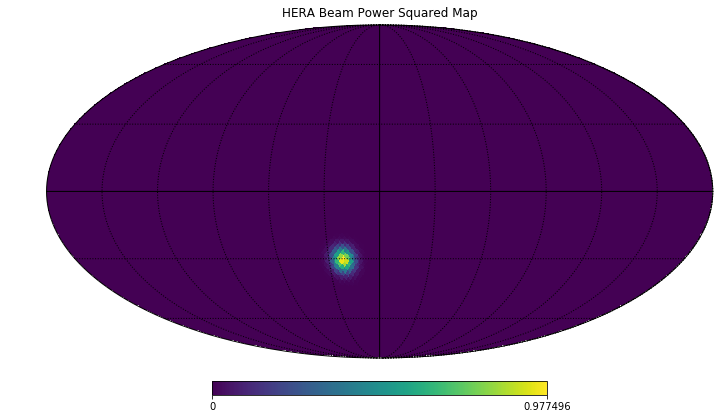

In [9]:
# for those curious about the process for rotating the beam...
print('HERA Location: {} deg S, {} deg E'.format(-np.degrees(lat), np.degrees(lon)))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
hpy.mollview(A2vals[0], title='HERA Beam Power Squared Map', hold=True)
hpy.graticule()
plt.show()

**Figure 1 |** Mollweide view of a HEALPix map used to model the beam-power-squared. This figure shows that the passive transformations used in the numerical integration scheme accurately produce a Gaussian beam centered at the HERA telescope location.

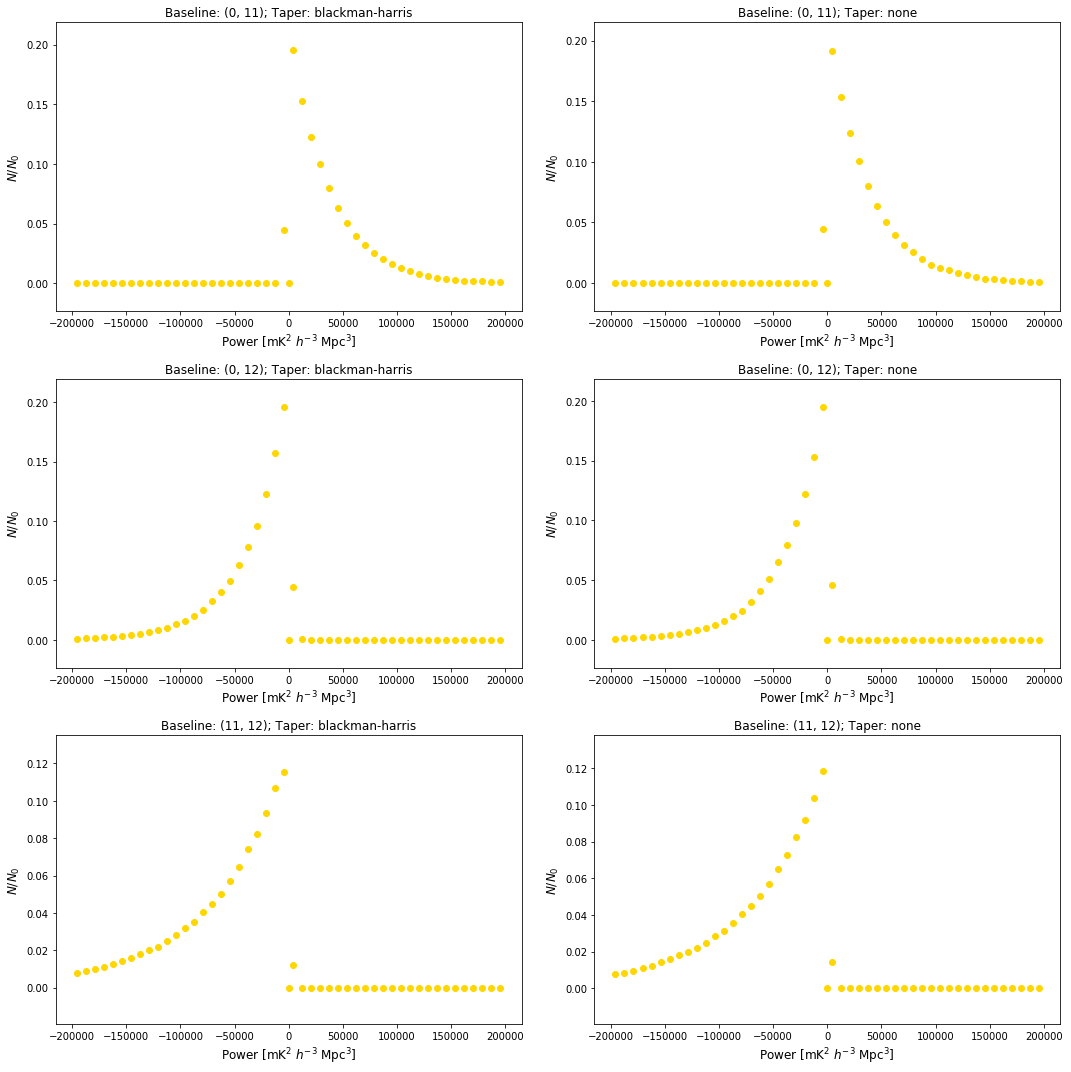

In [10]:
tapers = ['blackman-harris', 'none']
powers = 0.5*(bins[:-1]+bins[1:])

fig = plt.figure(figsize=(15,15))
axes = fig.subplots(3,2)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        bl = bls[i]
        axes[i,j].set_xlabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]',
                             fontsize=12)
        axes[i,j].set_ylabel(r'$N/N_0$', fontsize=12)
        axes[i,j].set_title('Baseline: {}; Taper: {}'.format(bls[i], tapers[j]))
        axes[i,j].scatter(powers, hist[j,i].imag, marker='o', color='gold', label='Imag')
plt.tight_layout()
plt.show()

**Figure 2 |** Histograms of the imaginary component of the power spectra computed from time-offset visibilities. The distributions clearly exhibit baseline dependence. The expected distribution is currently unknown. The origin of the bump that occurs on the side opposite that of the majority of the distribution for each histogram is also unknown (just to the right of zero for (0,12) and (11,12) and just to the left of zero for (0,11)).